In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(SeNetBlock, self).__init__()
        # 准备工作
        self.prepare = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
        )
        # 第一个卷积
        self.myconv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        # 传统卷积
        self.myconv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        )
        # stride = 2 或者 channel 改变 都需要使用卷积层
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
            )

        # SE layers
        self.fc1 = nn.Conv2d(out_channels, out_channels//16, kernel_size=1)
        self.fc2 = nn.Conv2d(out_channels//16, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.prepare(x)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.myconv1(out)
        out = self.myconv2(out)
        # Squeeze
        w = F.avg_pool2d(out, out.size(2))
        w = F.relu(self.fc1(w))
        w = F.sigmoid(self.fc2(w))
        # Excitation
        out = out * w
        out += shortcut
        return out


class SENet(nn.Module):
    def __init__(self, block=SeNetBlock, num_blocks=[2,2,2,2], num_classes=10):
        super(SENet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,  64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



net = SENet()
y = net(torch.randn(1,3,32,32))
print(y.size())
print(net)
net = net.cuda()

torch.Size([1, 10])
SENet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): SeNetBlock(
      (prepare): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
      (myconv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (myconv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (fc1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
      (fc2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): SeNetBlock(
      (prepare): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1

Files already downloaded and verified
Files already downloaded and verified
torch.Size([4, 3, 32, 32])


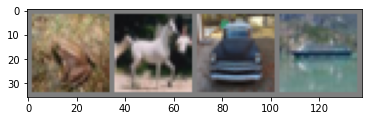

frog  horse car   ship 


In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#每次dataloader加载数据时：dataloader一次性创建num_worker个worker，
#（也可以说dataloader一次性创建num_worker个工作进程，worker也是普通的工作进程），
#并用batch_sampler将指定batch分配给指定worker，worker将它负责的batch加载进RAM
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
# show images
#make_grid的作用是将若干幅图像拼成一幅图像
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
losses = []
accuracys = []
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs=inputs.cuda()
        outputs = net(inputs)
        outputs=outputs.cuda()
        labels=labels.cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print(i)
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            losses.append(running_loss / 2000)
            running_loss = 0.0
    # dev
    mycorrect = 0
    mytotal = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images= images.cuda()
            labels = labels.cuda()
            # calculate outputs by running images through the network
            outputs = net(images)
            outputs = outputs.cuda()
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            mytotal += labels.size(0)
            mycorrect += (predicted == labels).sum().item()
    print(f'Accuracy of the network on the 10000 test images: {100 * mycorrect // mytotal} %')
    accuracys.append(100 * mycorrect // mytotal)
print('Finished Training')

/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[1,  2000] loss: 1.869
[1,  4000] loss: 1.560
[1,  6000] loss: 1.390
[1,  8000] loss: 1.265
[1, 10000] loss: 1.162
[1, 12000] loss: 1.067
Accuracy of the network on the 10000 test images: 63 %
[2,  2000] loss: 0.949
[2,  4000] loss: 0.944
[2,  6000] loss: 0.882
[2,  8000] loss: 0.854
[2, 10000] loss: 0.831
[2, 12000] loss: 0.774
Accuracy of the network on the 10000 test images: 72 %
[3,  2000] loss: 0.660
[3,  4000] loss: 0.678
[3,  6000] loss: 0.681
[3,  8000] loss: 0.652
[3, 10000] loss: 0.627
[3, 12000] loss: 0.629
Accuracy of the network on the 10000 test images: 75 %
[4,  2000] loss: 0.498
[4,  4000] loss: 0.529
[4,  6000] loss: 0.513
[4,  8000] loss: 0.504
[4, 10000] loss: 0.516
[4, 12000] loss: 0.510
Accuracy of the network on the 10000 test images: 77 %
[5,  2000] loss: 0.373
[5,  4000] loss: 0.393
[5,  6000] loss: 0.408
[5,  8000] loss: 0.421
[5, 10000] loss: 0.414
[5, 12000] loss: 0.419
Accuracy of the network on the 10000 test images: 80 %
[6,  2000] loss: 0.277
[6,  4000] l

Text(0.5, 1.0, 'SeNet loss')

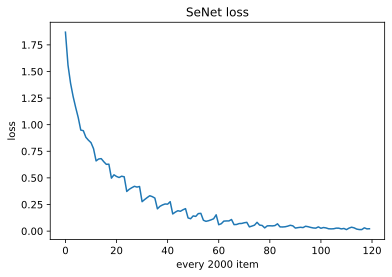

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'svg'
plt.figure()
plt.plot(losses)
plt.xlabel("every 2000 item")
plt.ylabel("loss")
plt.title("SeNet loss")

[63, 72, 75, 77, 80, 80, 81, 81, 81, 81, 80, 80, 81, 81, 82, 81, 82, 82, 83, 82]


Text(0.5, 1.0, 'SeNet accuracy')

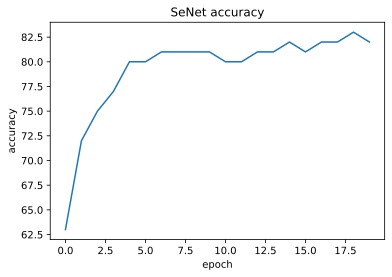

In [7]:
print(accuracys)
plt.plot(accuracys)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("SeNet accuracy")

Text(0.5, 1.0, 'SeNet accuracy')

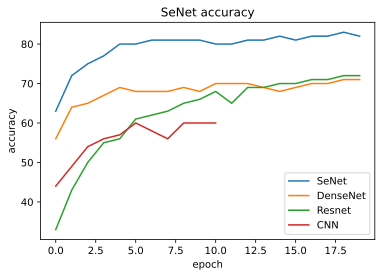

In [10]:
se = [63, 72, 75, 77, 80, 80, 81, 81, 81, 81, 80, 80, 81, 81, 82, 81, 82, 82, 83, 82]
dense = [56, 64, 65, 67, 69, 68, 68, 68, 69, 68, 70, 70, 70, 69, 68, 69, 70, 70, 71, 71]
res = [33, 43, 50, 55, 56, 61, 62, 63, 65, 66, 68, 65, 69, 69, 70, 70, 71, 71, 72, 72]
baseline = [44, 49, 54, 56, 57, 60, 58, 56, 60, 60,60]
plt.plot(se)
plt.plot(dense)
plt.plot(res)
plt.plot(baseline)
plt.legend(["SeNet","DenseNet","Resnet","CNN"])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("SeNet accuracy")